In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

In [2]:
df = pd.read_csv('data/ParisHousing.csv') #loads data

In [3]:
pd.set_option('display.precision', 2) #formatting for printed output
#remove binary features from summary
df.drop(columns = ['hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector',
                   'hasStorageRoom', 'hasGuestRoom']).describe().T

,count,mean,std,min,25%,50%,75%,max
squareMeters,10000.0,4.99e+04,2.88e+04,89.0,2.51e+04,5.01e+04,7.46e+04,1.00e+05
numberOfRooms,10000.0,5.04e+01,2.88e+01,1.0,2.50e+01,5.00e+01,7.50e+01,1.00e+02
floors,10000.0,5.03e+01,2.89e+01,1.0,2.50e+01,5.00e+01,7.60e+01,1.00e+02
cityCode,10000.0,5.02e+04,2.90e+04,3.0,2.47e+04,5.07e+04,7.57e+04,1.00e+05
cityPartRange,10000.0,5.51e+00,2.87e+00,1.0,3.00e+00,5.00e+00,8.00e+00,1.00e+01
numPrevOwners,10000.0,5.52e+00,2.86e+00,1.0,3.00e+00,5.00e+00,8.00e+00,1.00e+01
made,10000.0,2.01e+03,9.31e+00,1990.0,2.00e+03,2.01e+03,2.01e+03,2.02e+03
basement,10000.0,5.03e+03,2.88e+03,0.0,2.56e+03,5.09e+03,7.51e+03,1.00e+04
attic,10000.0,5.03e+03,2.89e+03,1.0,2.51e+03,5.04e+03,7.54e+03,1.00e+04
garage,10000.0,5.53e+02,2.62e+02,100.0,3.28e+02,5.54e+02,7.77e+02,1.00e+03


Classification on cityPartRange (1-10 value representing the desirability of a neighborhood)

In [ ]:
X = df.drop(columns='cityPartRange')
y = df.cityPartRange
# split 50% training data, 50% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.5,
                                                  random_state=0, stratify=y)
# of remaining 50%, split in half to get 25% validation, 25% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)

In [ ]:
def find_best_clf(clfs, params, X_train, X_valid, y_train, y_valid, only_best = True):
  #combines clfs and gridsearch params into a dataframe
  models = pd.DataFrame({'clf':clfs, 'params':params})
  #creates a grid search of each clf with associated params
  models['gridsearch'] = models.apply(lambda x: GridSearchCV(x['clf'], x['params'], n_jobs =-1, refit=True), 
                                      axis = 1)
  #fits each grid search to training data
  models.apply(lambda x: x['gridsearch'].fit(X_train, y_train), axis=1)
  #finds accuracy score of each clf on validation data
  models['accuracy'] = models.apply(lambda x: x['gridsearch'].score(X_valid, y_valid), axis = 1)
  #sorts models by accuracy
  models.sort_values('accuracy', ascending=False, inplace=True)
  #returns estimator with highest validation accuracy if only_best is true
  #else returns dataframe of all gridsearchs and acurracies sorted by accuracy
  return models.iloc[0].gridsearch.best_estimator_ if only_best else models[['gridsearch','accuracy']]

In [ ]:
clf = [#DecisionTreeClassifier(random_state=0),
       Pipeline(steps=[('pca', PCA()), ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
      ]
params = [
        #{
        #    'max_depth': np.arange(1,20,2), 
        #    'min_samples_split': np.arange(2,20,2),
        #    'min_samples_leaf': np.arange(1,20,2)
        #},
        {
            'pca__n_components': np.arange(1,10),
            'knn__n_neighbors': np.arange(1,20,2),
            'knn__leaf_size': np.arange(1,20,2),
            'knn__p':[1,2]
        }
         ]
grid_search = find_best_clf(clf, params, X_train, X_valid, y_train, y_valid)

In [ ]:
grid_search.score(X_test, y_test)

Regression on price

In [4]:
#X = df.drop(columns='price') change to the variables below (from r)
X = df[["squareMeters"]]
y = df.price
# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0)
# of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0)

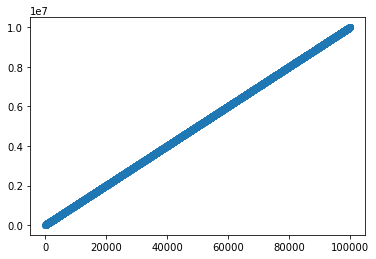

In [5]:
# tried only squareMeters and [squareMeters,other significant variables] and the MSE's still crazy and the accuracy is pretty much the same
# after plotting price vs squareMeters, the relationship is straight up linear
X.corr()
df.isnull().sum()
plt.scatter(X,y)
# the high MSE is probably from the nature of the price values in the data
# also this explains the ungodly high accuracy

In [6]:
#OLS regression
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

MSE_train = (1/y_train.size) * np.sum((y_train - model.predict(X_train))**2)
MSE_test = (1/y_test.size)  * np.sum((y_test - model.predict(X_test))**2)

print(f'training score = {score_train}\ntesting score = {score_test}')
print(f'MSE train = {MSE_train}\nMSE test = {MSE_test}')

training score = 0.9999987238468948
testing score = 0.9999987175180519
MSE train = 10639145.115181468
MSE test = 10528759.486007515


In [7]:
#kNN regression
model = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
model.fit(X_train, y_train)

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

MSE_train = (1/y_train.size) * np.sum((y_train - model.predict(X_train))**2)
MSE_test = (1/y_test.size)  * np.sum((y_test - model.predict(X_test))**2)

print(f'training score = {score_train}\ntesting score = {score_test}')
print(f'MSE train = {MSE_train}\nMSE test = {MSE_test}')

training score = 0.9999989281857226
testing score = 0.9999982249248962
MSE train = 8935595.256884217
MSE test = 14572789.008809505


In [8]:
#lasso regression
model = linear_model.Lasso(max_iter=2000)
model.fit(X_train, y_train)

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

MSE_train = (1/y_train.size) * np.sum((y_train - model.predict(X_train))**2)
MSE_test = (1/y_test.size)  * np.sum((y_test - model.predict(X_test))**2)

print(f'training score = {score_train}\ntesting score = {score_test}')
print(f'MSE train = {MSE_train}\nMSE test = {MSE_test}')
print(f'coefficients = {model.coef_}')

training score = 0.9999987238468948
testing score = 0.9999987175180525
MSE train = 10639145.11518143
MSE test = 10528759.481167357
coefficients = [100.00006696]


In [9]:
#ridge regression
model = linear_model.Ridge(alpha=0.1)
model.fit(X_train, y_train)

score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

MSE_train = (1/y_train.size) * np.sum((y_train - model.predict(X_train))**2)
MSE_test = (1/y_test.size)  * np.sum((y_test - model.predict(X_test))**2)

print(f'training score = {score_train}\ntesting score = {score_test}')
print(f'MSE train = {MSE_train}\nMSE test = {MSE_test}')
print(f'coefficients = {model.coef_}')

training score = 0.9999987238468948
testing score = 0.9999987175180519
MSE train = 10639145.115181472
MSE test = 10528759.486001361
coefficients = [100.00006696]


In [ ]:
#kernel regression